# Project - Retail Product classification

Kaggel Name: Markus Obert

This notebook was created for the lecture Data Science in the summer term 2021. The project deals with a Kaggle competition where product categories are predicted based on images and their product description.

**Data description:**
* There is Dataset of 42000 products with 21 different product categories. For every product there is an image, the title of the product and the a description given.

**Ideas and diffrent approaches:**

Different networks for text and image classification were trained and combined in different ways to create the best possible classifier.
* Text networks:
  * Word2Vec
  * Different pretrained BERT networks 

* Image networks:
  * VGG19
  * Xception
  * ResNet152

**Solution approach:**

* Image classification is performed by the network "ResNet152". Thereby the weights are pre-trained by the "ImageNet" dataset.
  * For this purpose, a fully connected layer was added at the end of the network and the last convolutional layer of the pre-trained network was trained with finetuning.
* The text-based classification is performed by the "BERT" network.
  * Here the best solution was the network: small_bert/bert_en_uncased_L-4_H-512_A-12
* Both networks are connected at the end
* The image and text dataset is preprocessed beforehand
* Regularizaton has been applied

## Preparation


### Import the Data from Kaggle

In [3]:
#Mount google drive to save/load weigths 
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [4]:
! pip install -q kaggle
from google.colab import files
print("Choose the kaggel.jason file on your computer")
files.upload() 

Choose the kaggel.jason file on your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"markusobert","key":"30038eb93ff5cf15ed893d1c63010bcc"}'}

In [11]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle
# Download of the data from kaggle
! kaggle competitions download -c retail-products-classification

     |████████████████████████████████| 58 kB 6.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ac1108b335031cb1062f6f8046c6c72a36a26ecc55b5a744629621951ea3d01e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 99% 257M/259M [00:03<00:00, 96.9MB/s]
100% 259M/259M [00:03<00:00, 85.1MB/s]


In [12]:
# Create a directory and unzip the files there
! mkdir retail-products-classification
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null

### Importing the necessary libraries

In [5]:
# Installations
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 15.2 MB/s 
     |████████████████████████████████| 1.6 MB 13.2 MB/s 
     |████████████████████████████████| 90 kB 12.7 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 352 kB 64.8 MB/s 
     |████████████████████████████████| 37.1 MB 80 kB/s 
     |████████████████████████████████| 211 kB 70.9 MB/s 
     |████████████████████████████████| 99 kB 11.5 MB/s 
     |████████████████████████████████| 679 kB 48.3 MB/s 
     |████████████████████████████████| 636 kB 47.5 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 


In [13]:
!pip install keras_metrics &> /dev/null
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline
from sklearn.metrics import accuracy_score

# Textclassification
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

# Image classification
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras import layers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
import numpy as np
import tensorflow as tf
from tensorflow import keras



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### List of classes
This is the List of the 21 classes in wich the products have to be categorize

In [14]:
CATEGORIES = ['Electronics', 
              'Sports & Outdoors',
              'Cell Phones & Accessories',
              'Automotive',
              'Toys & Games',
              'Tools & Home Improvement', 
              'Health & Personal Care', 
              'Beauty',
              'Grocery & Gourmet Food', 
              'Office Products',
              'Arts, Crafts & Sewing',
              'Pet Supplies', 
              'Patio, Lawn & Garden',
              'Clothing, Shoes & Jewelry', 
              'Baby',
              'Musical Instruments',
              'Industrial & Scientific', 
              'Baby Products',
              'Appliances',
              'All Beauty',
              'All Electronics']

## Exploratory Data Analytics


*   Visualize
*   Pre-process
*   clean



### Analysis of the product description


#### Read the train.csv file

In [15]:
data = pd.read_csv('retail-products-classification/train.csv')
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


#### Distribution of samples in each categories
First have a look how the data is distributed. In this case the data is nearly equally distributed

In [ ]:
#data['categories'].value_counts().plot(kind='bar', figsize=(14, 3));
data['categories'].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Appliances                   2200
Clothing, Shoes & Jewelry    2200
Musical Instruments          2200
Office Products              2200
Pet Supplies                 2200
Toys & Games                 2200
All Electronics              2200
Industrial & Scientific      2200
All Beauty                   2200
Tools & Home Improvement     2200
Electronics                  2200
Automotive                   2200
Baby Products                2200
Health & Personal Care       2200
Baby                         2200
Cell Phones & Accessories    2200
Patio, Lawn & Garden         2200
Name: categories, dtype: int64

#### Characters in the title and the description
Have a look at the size of the distribution of the description length. In the Histogramm you can see the most Descriptions have not more than 5000 characters. But there are also some outliers with a lot of more chrachters up to 20000.

Text(0.5, 1.0, 'Characters in the description')

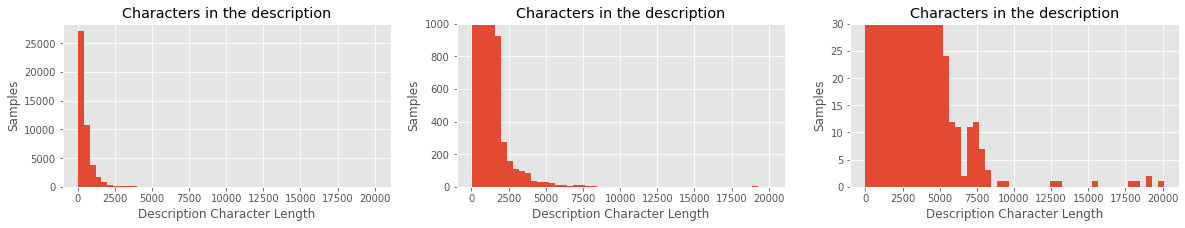

In [ ]:
#get the number of characters
char_num=data['description'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the description')

axes[1].hist(char_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the description')

axes[2].hist(char_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the description')

When you have a look at the description with the most characters you can see there is a lot of trash in the description. Maybe some html code or something different. So for classification we have to drop the trash of the description. To simplify just use the head of the description.

In [ ]:
#Description with the most words
data['description'].iloc[char_num.argmax()]

'Turbo.264 HD Video Encoder &amp; AcceleratorConvert HD video to the universal H.264 formatThe Turbo.264 HD is a USB hardware device and accompanying Mac software that works together to dramatically accelerate the conversion of video to H.264 format.H.264 video is a universal format that can be played on iPod, iPhone, Apple TV, gaming consoles, YouTube, and much more.The Turbo.264 HD accepts nearly any video file and outputs high quality H.264 video, in formats up to full 1080P HD.[if gte mso 9]><xml> <w:WordDocument> <w:View>Normal</w:View> <w:Zoom>0</w:Zoom> <w:TrackMoves  /> <w:TrackFormatting  /> <w:PunctuationKerning  /> <w:ValidateAgainstSchemas  /> <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid> <w:IgnoreMixedContent>false</w:IgnoreMixedContent> <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText> <w:DoNotPromoteQF  /> <w:LidThemeOther>EN-US</w:LidThemeOther> <w:LidThemeAsian>X-NONE</w:LidThemeAsian> <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript> <w:Compati

Also you can see there are 1042 articel without any description (NaN) and one articel with no title.

In [ ]:
#count the NaN values
print(data['description'].isnull().sum())
print(data['title'].isnull().sum())
print(data['ImgId'].isnull().sum())
print(data['categories'].isnull().sum())

1042
1
0
0


Later one can combine the title and the description so that there will be enough characters/words for description. But first have a look if they are all of a specific categorie. So when we drop all the products with no description the datset of the classes "Automotive" and "Industrial and Scientific" will be reduce by nearly 10 %

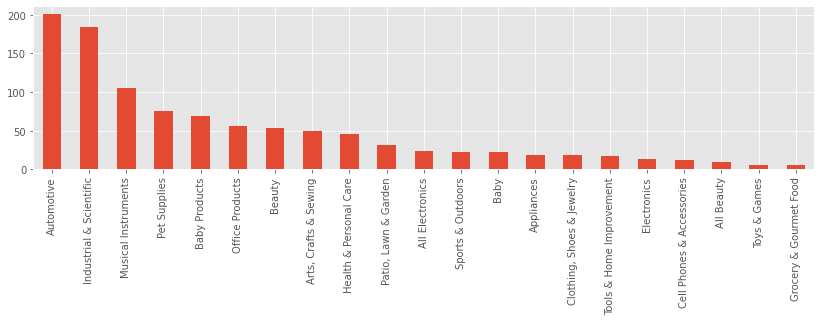

In [ ]:
#Distribution of the nan values in the discription in the different categories
#Get the categories of the products where de description is nan
data_nodescrip=data[data['description'].isnull()]
data_nodescrip['categories'].value_counts().plot(kind='bar', figsize=(14, 3));

Now also have a look to the number of characters in the title. So there are also a few products with a pretty long title. But the most title have less then 100 characters.

Text(0.5, 1.0, 'Characters in the title')

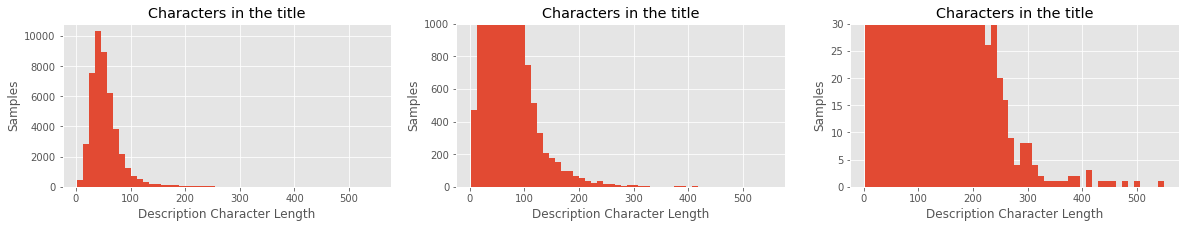

In [ ]:
char_num_title=data['title'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the title')

axes[1].hist(char_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the title')

axes[2].hist(char_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the title')

In [ ]:
#Title with the most words
data['description'].iloc[char_num_title.argmax()]

'Heavy Duty Luxurious Pashmina Shawl, Wrap And Scarf - Perfect Accessory For Any Seasons, Event or Occasion! You Will Feel So Great Due To This Pashmina Wool is The Finest Cashmere From Inner Mongolia-High Mountain Goat Fur,The Most Soft Wool. All Natural With No Any Imitation or Man Made Materials. Heavy Duty With Soft Touch,Look Fashionable & Stylish , Perfect Size at 27" Width x 70" Length + 3" x 2 Fringe ,Good for Your Wrap ,Shawl and Scarf . A Perfect Item For Christmas Gifts or Birthday Gifts , Super Saving,100% Satisfaction Guaranteed'

In [ ]:
#Check for titles with only a few characters in the title
data_short_title=data[data['title'].str.len()<5]
print("Number of titels with less then 5 characters:  ", data_short_title['title'].count())
data_short_title

Number of titels with less then 5 characters:   7


,ImgId,title,description,categories
5591,1934857602,Poo,It&#x2019;s been a tough day in the monkey cag...,Toys & Games
7470,291484980X,Evo,The island of Krah is home to nomadic tribes a...,Toys & Games
20054,B0000T16L8,Rolo,"Two great flavors in one, ROLO candy is made u...",Grocery & Gourmet Food
24275,B00012NBZS,DHEA,"Vitamin Shoppe Dhea, 50 mg, 100 capsules",Health & Personal Care
33614,B0000CA2RD,Zori,Sandals made of straw weave patterns. Black tr...,Sports & Outdoors
34082,B000HLDCUW,Aida,Myto 2MCD 064.333. Original 2006 MYTO pressing.,"Arts, Crafts & Sewing"
35538,B00000IWD6,Rook,"With its numbered deck of 57 cards, Rook, the ...",Toys & Games


#### Words in the title and the description
Have a look at the size of the distribution of the number of words. In the Histogramm you can see the most Descriptions have not more than 250words.

Text(0.5, 1.0, 'Words in the description')

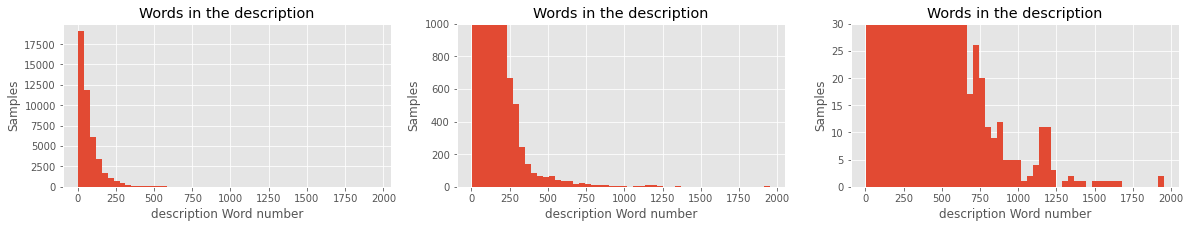

In [ ]:
#calculate hte number of words
word_num=data['description'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('description Word number')
axes[0].set_title('Words in the description')

axes[1].hist(word_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('description Word number')
axes[1].set_title('Words in the description')

axes[2].hist(word_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('description Word number')
axes[2].set_title('Words in the description')

In the title there are most of the time less then 20 words

Text(0.5, 1.0, 'Words in the title')

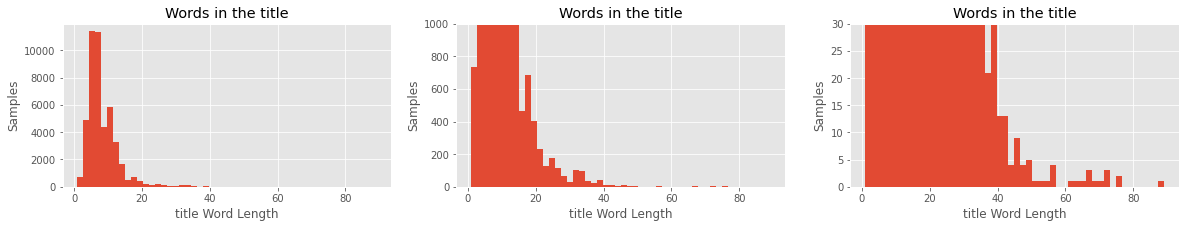

In [ ]:
word_num_title=data['title'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('title Word Length')
axes[0].set_title('Words in the title')

axes[1].hist(word_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('title Word Length')
axes[1].set_title('Words in the title')

axes[2].hist(word_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('title Word Length')
axes[2].set_title('Words in the title')

#### Merge title and description
In above analysis one can see there are a few products without any description, a few with a very short title and so on. Because of this you should combine the title and the description of the products.

In [ ]:
#Creating pandas dataframe with merged description
data_merge = pd.DataFrame({'ImgId':data['ImgId'],
                        'description':data['title']+" "+data['description'],
                        'categories':data['categories']})
data_merge.head()

,ImgId,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE Solder Pick f...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T6...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light This twoway light featu...,Health & Personal Care


#### Number of words in merged description
One can see there are a few merged descriptions with just a few words. But there is no description without words

Text(0.5, 1.0, 'Words in the description')

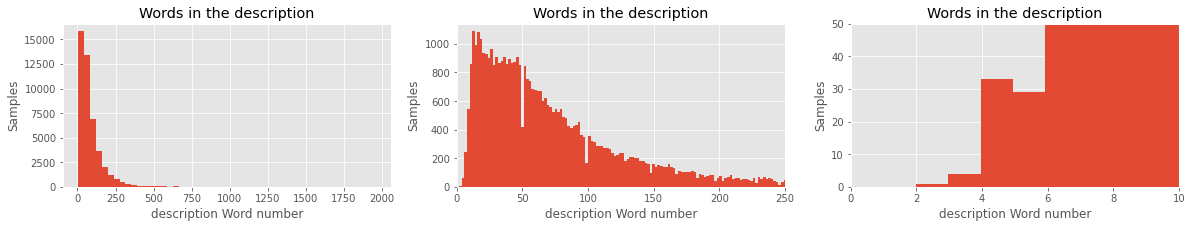

In [ ]:
#calculate hte number of words
word_num=data_merge['description'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('description Word number')
axes[0].set_title('Words in the description')

axes[1].hist(word_num, bins=1000)
axes[1].set_xlim([0, 250])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('description Word number')
axes[1].set_title('Words in the description')

axes[2].hist(word_num, bins=2000)
axes[2].set_ylim([0, 50])
axes[2].set_xlim([0, 10])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('description Word number')
axes[2].set_title('Words in the description')

Look for a few examples with less words, how good the product description of them is.
One can see there some times the same words in the title and in the description. Furthermore there are one word who describes the product and the other word is a brand name

In [ ]:
#Check for descriptions with only a few words in it
data_short_title=data_merge[data_merge['description'].str.split().str.len()<5]
print("Number of titels with less then 5 Words:  ", data_short_title['description'].count())
data_short_title

Number of titels with less then 5 Words:   38


,ImgId,description,categories
791,B0000AL2UC,Nokia 8310 Nokia 8310,Cell Phones & Accessories
912,B0000AVBE4,Athletic Cup Cup only.,Sports & Outdoors
3261,B0000BWBNY,Lindy Marker Buoy .,Sports & Outdoors
3506,B0000CEFOF,Tiger-Dragon Patch Tiger-Dragon Patch,Sports & Outdoors
4619,B001HSEEB0,Bosch 475225 PANEL-FACIA PANEL-FACIA,Appliances
5738,B000E438LA,Check/Anti-siphon Valve Err:509,Industrial & Scientific
5794,B0000VLRBK,Amaretto Oil Amaretto Oil,Grocery & Gourmet Food
7377,B0002QTHR4,Water Dancers Water dancers,Automotive
8884,B0001J2NDW,"COCOA,STARBUCKS,GOUR,24BX COCOA,STARBUCKS,GOUR...",Grocery & Gourmet Food
12181,B00294KXKW,"Frigidaire FGHD2433K, Black Dishwashers",Appliances


#### Clean descriptions

To get just the important words out of the description. Firstly they will be filtered so that the following stuff is out of the description: 

*   all characters will be converted to small one
*   delete special characters '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
*   Words with less then 2 characters
*   english stop words (e.g. about above all an for few ....) 
*   use only the first 250 words


In [ ]:
#manual filtering of the descriptions
def filter_description (text_data):
    # extract numbers and special characters
    # convert all characters to lower
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n123456789',
          lower=True,
          split=' ' 
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    # data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]
    # Put the single words back in sentences
    listToStr = ' '.join([str(elem) for elem in data_words])
     #put the strings together
    filters="',"
    for x in range(len(filters)):
        text_fil= listToStr.replace(filters[x],"")
    #return data_words  
    return text_fil 

In [ ]:
#just for debugging to get the raw dataset again
del data
del data_filtered
del data_merge
data = pd.read_csv('retail-products-classification/train.csv')

In [ ]:
#Creating pandas dataframe with merged description
data_merge = pd.DataFrame({'ImgId':data['ImgId'],
                        'description':data['title']+" "+data['description'],
                        'categories':data['categories']})

In [ ]:
data_filtered = []
#filter every description with the above functions
for i in range(0,data_merge.shape[0]):
    data_filtered.append(filter_description(str(data_merge['description'].iloc[i])))



In [ ]:
#here are exmaples of how the text got filtered
n=2
for n in range(3):
    n = n *42
    print(data_merge['description'].iloc[n])
    print(data_filtered[n])
    print("")

TUNGSTEN SOLDER PICK WITH HANDLE Solder Pick for picking up molten solder when making jewelry
tungsten solder pick handle solder pick picking molten solder making jewelry

18mm x 1.5 High Speed Steel Plug Tap High Speed Steel. Plug Style (most common hand tap). Ground Thread.
high speed steel plug tap high speed steel plug style common hand tap ground thread

Celltronix Universal Rechargeable Dual USB Portable Power Pack A UNIVERSAL backup power solution for all your devices!* 4000mA gives enough power for extended use or higher power devices* Up to 8x more battery life for some devices!* 2 USB ports allow you to charge 2 USB devices at the same time* Includes adapters for the most popular electronic devices (including micro USB mini USB and iPod/iPhone 3G)* Charge the internal battery with included AC DC and USB chargers
celltronix universal rechargeable dual usb portable power pack universal backup power solution devices gives enough power extended use higher power devices battery li

### Image Analyse

Just have a look how the pictures look like

In [ ]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('retail-products-classification/train/train/*.jpg'): #assuming .jpg
    im=Image.open(filename)
    image_list.append(im)


iterations:  18


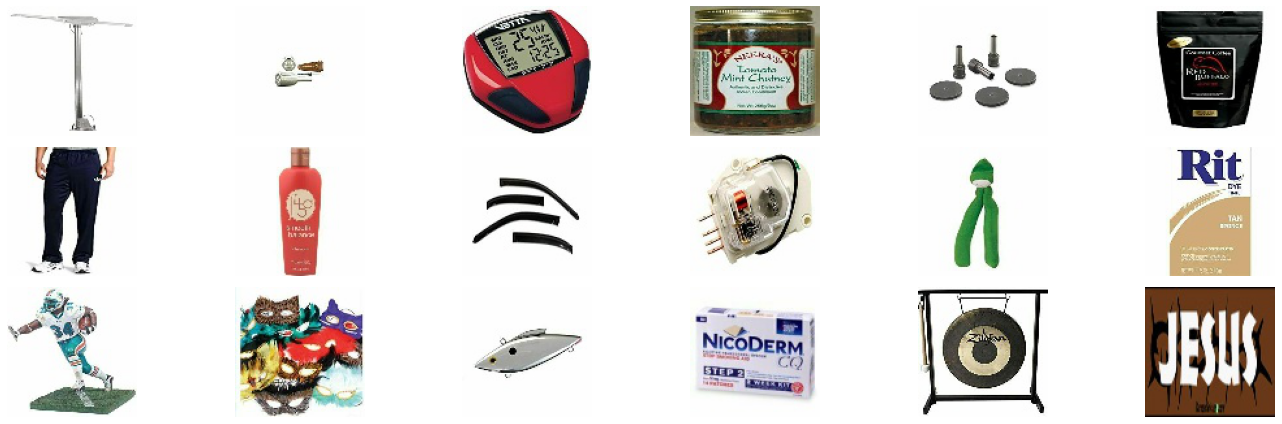

In [ ]:
j = 1   # counter for loop iterations
rows = 3
columns = 6
stepsize = 42
fig = plt.subplots(rows, columns, figsize=(20,6))
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image_list[i])
    j += 1

plt.tight_layout()
print('iterations: ', j-1)


# Read the data

Read  all the data(pictures and images) and bring them together. Also do some prefiltering of the text like mentioned in the chapter before and do some image preprocessing. 

**Prameters**


In [16]:
train_images_path = 'retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = len(CATEGORIES)

**Functions**

In [17]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [18]:
#loading the images and create an array of them
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [19]:
#Filtering the descriptions (special tokens, short words, stop words, number of words)
def filter_description (text_data):
    # extract numbers and special characters
    # convert all characters to lower
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n1234567890',
          lower=True,
          split=' ' 
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    #data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]
    # Put the single words back in sentences
    listToStr = ' '.join([str(elem) for elem in data_words])
     #put the strings together
    filters="',"
    for x in range(len(filters)):
        text_fil= listToStr.replace(filters[x],"")
    #return data_words  
    return text_fil 
    #return text_data # no filtering

### Image Preprocessing

In [20]:
#Normalization
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

### Read Data
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category. 

In [21]:
#Time: 2:48 min
corpus = []
images = []
labels = []
image_id = []
#get a list of all files in the directory
files = os.listdir(train_images_path)
random.shuffle(files)

#iterate trough every single image in the list files
for img in files:
    #get the id of the image by removing the .jpeg
    img_id = img.split('.')[0]
    #create the image(size 80x80, rgb, convert into array)
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            #read the data of the image in the row with the image id
            index = data[data['ImgId']==img_id].index.values[0]
            #write the data into row
            row = data.iloc[index , :]
            #family = category of the image
            family = row[3]
            #if the family of the products is in the define categories
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                #adds an item to the end of the list images
                images.append(img_array.astype('float32'))
                #get a list with all tokens (words) in the description and title, own prefiltering 
                token_list = filter_description(str(title) + ' ' + str(description))#changed
                #adds the words of the current token_list to the corpus (Textsammlung)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

#converting
#corpus = alle Beschreibungen 
images = np.asarray(images)
labels = pd.get_dummies(labels).values  #on hot encoded labels
images = preprocess_input(images)

# Textclassification with BERT
The Textclassification with BERT, first was implemented sperately an was trained just on the descriptions.
BERT means Bidirectional Encoder Representations from Transformers (BERT) and is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google(wikipeadia) 

**Parameters**


In [22]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE


## Create the Dataset Input for the Model
create a Dataset, shuffel and prefetch it, to speed up the training

In [23]:
#Train test Split:
p = int((len(image_id)*80)/100)

#train data
train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
#test data
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

print('train data:',len(train_data_raw))
print('train labels:',len(train_labels_onehot))
print('test data:',len(test_data_raw))
print('test_labels:',len(test_labels_onehot))

train data: 33600
train labels: 33600
test data: 8400
test_labels: 8400


In [24]:
#create a Dataset, shuffel and prefetch it, to speed up the training
train_ds=tf.data.Dataset.from_tensor_slices((train_data_raw,train_labels_onehot))
train_ds= train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds=tf.data.Dataset.from_tensor_slices((test_data_raw,test_labels_onehot))
test_ds= test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Used BERT-Modelle**
1. small bert L-4_H-512_A-8 (train fast, accuracy on submission of 0,83 by 25 epoches)
2. bert_en_uncased_L-12_H-768_A-12 (trains slow 900 s per epoche)

In [25]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library.


In [26]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Test of the preprocessing

In [27]:
text_test = ['Test how the toknizer works']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 3231 2129 1996 2000 2243 3490 6290 2573  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


you get 3 outputs from the preprocessing that a BERT model uses(`input_words_id`, `input_mask` and `input_type_ids`).


## Using the BERT model

Test of the Output of the BERT Model

In [28]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [29]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9810979   0.7679231  -0.29407486  0.2552466  -0.50647503  0.48745114
  0.99533564 -0.7987165  -0.39974895 -0.9671072   0.07749581 -0.9885023 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-1.6426854e-03  2.2269723e-01  6.5379751e-01 ... -6.9148725e-01
   8.1796962e-01  1.6680069e+00]
 [-5.4676747e-01  3.2115415e-01  3.7330568e-01 ... -6.6274858e-01
   4.7066823e-02  1.6138370e+00]
 [-2.3893297e-01  6.8877900e-01  2.3869698e-01 ... -5.7696021e-01
  -2.7807629e-01  8.8928366e-01]
 ...
 [-1.4374468e-01  1.1608787e-01  1.0812831e+00 ... -5.4038954e-01
   3.7956703e-01  1.3437957e+00]
 [ 1.3462281e-01  1.5471312e-01  3.6073259e-01 ...  1.1437838e-01
   1.5190811e+00  2.8925222e-01]
 [-1.4504805e-01  3.6907566e-01  6.3715033e-02 ...  1.5245695e-01
   1.6715618e+00  2.5315896e-01]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. It's an embedding for the description
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. This as a contextual embedding for every token in the descriptions.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

## Define the model

very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.


In [30]:
# Model for just doing the classification with the BERT model --> Last layer fc21 with softmax
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing',trainable=False)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(128,activation='relu')(net)
  net = tf.keras.layers.Dense(21, activation='softmax')(net)
  return tf.keras.Model(text_input, net)

In [31]:
#seccond Model without a last dense Layer with just 21 neurons
def build_BERT_classifier():
      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
      preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing',trainable=False)
      encoder_inputs = preprocessing_layer(text_input)
      encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
      outputs = encoder(encoder_inputs)
      net = outputs['pooled_output']
      net = tf.keras.layers.Dropout(0.2)(net)
      net = tf.keras.layers.Dense(128,activation='relu')(net)
      net = outputs['pooled_output']
      return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [32]:
# version 1
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.5062833  0.5234978  0.50261956 0.507718   0.50891155 0.50460714
  0.5055557  0.506105   0.5335103  0.5311546  0.50527215 0.50265974
  0.50727606 0.56029695 0.5024369  0.50997394 0.50466436 0.5028751
  0.5129313  0.50652915 0.5047102 ]], shape=(1, 21), dtype=float32)


In [33]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

Here the BERT classifier gets finetuned. Then model_BERT2 will be taken as feature extractor in the final model and all the parameters of model_BERT2 will be freeze

In [34]:
# version 2, Finetune just the Bert model

model_BERT2= build_BERT_classifier()

modelBERT_fine= models.Sequential()  
modelBERT_fine.add(model_BERT2)
modelBERT_fine.add(layers.Dropout(0.2))              
modelBERT_fine.add(layers.Dense(NUM_CLASSES, activation='softmax'))

modelBERT_fine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 512)               28763649  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                10773     
Total params: 28,774,422
Trainable params: 28,774,421
Non-trainable params: 1
_________________________________________________________________


### Model structure

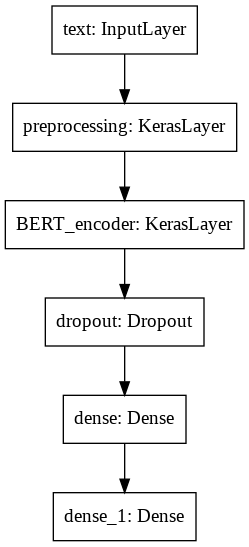

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training


### Loss function

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

### Optimizer

"Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
modelBERT_fine.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
#trains ca. 300 s per epoche
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,epochs=epochs,validation_data=test_ds)

In [ ]:
#trains ca. 300 s per epoche
print(f'Training model with {tfhub_handle_encoder}')
history = modelBERT_fine.fit(x=train_ds,epochs=epochs,validation_data=test_ds)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


1287/1287 [==============================] - 251s 189ms/step - loss: 1.9531 - categorical_accuracy: 0.4145 - val_loss: 1.0029 - val_categorical_accuracy: 0.6679
Epoch 2/10
1287/1287 [==============================] - 242s 188ms/step - loss: 0.8427 - categorical_accuracy: 0.7360 - val_loss: 0.7285 - val_categorical_accuracy: 0.7762
Epoch 3/10
1287/1287 [==============================] - 243s 189ms/step - loss: 0.5768 - categorical_accuracy: 0.8196 - val_loss: 0.6847 - val_categorical_accuracy: 0.7988
Epoch 4/10
1287/1287 [==============================] - 242s 188ms/step - loss: 0.4220 - categorical_accuracy: 0.8708 - val_loss: 0.6763 - val_categorical_accuracy: 0.8012
Epoch 5/10
1287/1287 [==============================] - 240s 186ms/step - loss: 0.3144 - categorical_accuracy: 0.9039 - val_loss: 0.6688 - val_categorical_accuracy: 0.8190
Epoch 6/10
1287/1287 [==============================] - 240s 186ms/step - loss: 0.2365 - categorical_accuracy: 0.9275 - val_loss: 0.6972 - val_categori

In [ ]:

#save the model to colab
classifier_model.save("saved_model/weights.model_BERTsmall_L4_64_l.h5")
#save the model to google drive
classifier_model.save("gdrive/MyDrive/model_BERTsmall_L4_64_l.h5")
classifier_model.save_weights("gdrive/MyDrive/model_BERTsmall_L4_64_l")


In [ ]:
#Load a model
model_loaded = keras.models.load_model('content/gdrive/')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

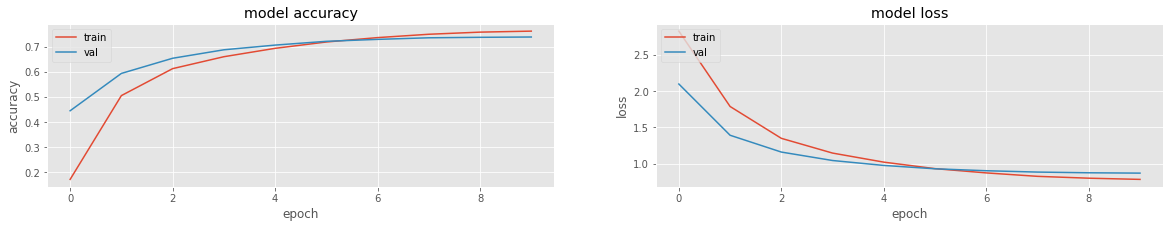

In [ ]:
history_bert = history.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history_bert['categorical_accuracy'])
axes[0].plot(history_bert['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')


## Submission only for BERT classifier

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(2)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...


In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(filter_description(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

### Create the input tensor

In [ ]:
del test_data_raw
del test_ds

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

#keine Ahnung was da passiert aber ohne den ganzen scheiß funzts ned, hab ich teilweise aus dem letzten laborversuch
test_ds_submission = tf.data.Dataset.from_tensor_slices(test_corpus)
test_ds_submission = test_ds_submission.batch(BATCH_SIZE)
test_ds_submission = test_ds_submission.cache().prefetch(buffer_size=AUTOTUNE)

Make prediction

In [ ]:
#pred_submission = classifier_model.predict(test_ds_submission)
pred_submission = modelBERT_fine.predict(test_ds_submission)
test_classes = np.argmax(pred_submission, axis = 1)
print(test_classes)
print(test_classes.shape)

[ 0  4 11 ...  1  9 13]
(6367,)


In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

## Conclusion BERT
With the textclassification it is possible to reach a score of arround 0,83 in the submission. So the Textclassification is very important for the product classification. The different tests have shown that it is better to use a smaller BERT model and rather add a smaller dense-layer at the end of the model. Otherwise, the model tends to overfit quickly. For further improvement of the model one would have to try text augmentation.

# Image Classification
Three different pre-trained models were tested for image classification. 
-  ResNet
-  Xception
-  VGG19

After the test it was shown that by transfer learning and finetuning with the ResNet the best result can be achieved only on images. (0,44). Therefore the ResNet was also used for the final model.

### Train test split

In [35]:
#Train test Split:
p = int((len(image_id)*80)/100)

train_image= images[:p]
train_labels_onehot = labels[:p]
test_image = images[p:]
test_labels_onehot = labels[p:]

print(len(train_image))
print(len(train_labels_onehot))
print(len(test_image))
print(len(test_labels_onehot))

33600
33600
8400
8400


## VGG 19

In [ ]:

input_tensor = Input(shape=INPUT_SHAPE)
model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor,
                 input_shape=(80, 80, 3), pooling=None,)
model.summary()

In [ ]:
modelVGG = models.Sequential()                #add fully connected layer at the end of the pretrained model
modelVGG.add(model)
modelVGG.add(layers.Flatten())
modelVGG.add(layers.Dense(256, activation='relu'))
modelVGG.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.trainable = False
modelVGG.summary()

FINETUNE = 0    # set or reset FINETUNE#

# output = tf.keras.layers.Reshape((4096,))(modelVGG.output)
# outputVGG = tf.keras.layers.Dense(NUM_CLASSES, activation='relu')(output)
#modelVGG.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5397      
Total params: 20,554,325
Trainable params: 529,941
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.01)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()
modelVGG.compile(optimizer=optimizer, loss=loss, metrics =metric)

In [ ]:
history_img = modelVGG.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=50)

## Xception

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
print(input_tensor)
modelXcep = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor,
                input_shape=(80, 80, 3), pooling=None)
modelXcep.summary()

In [ ]:
# freeze all parameters of the xception net for transfer learning
modelXcep.trainable = False

#add fully connected layer at the end of the pretrained model
modelXception = models.Sequential()                
modelXception.add(modelXcep)
modelXception.add(layers.Flatten())
modelXception.add(layers.Dense(2048,activation='relu'))
modelXception.add(layers.Dropout(0.2))
modelXception.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()

modelXception.compile(optimizer=optimizer, loss=loss, metrics=metric)

modelXception.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              37750784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                43029     
Total params: 58,655,293
Trainable params: 37,793,813
Non-trainable params: 20,861,480
_________________________________________________________________


### Data Augumentation
Variation of the train data to avoid overfitting. The used parameters doesn't work pretty good, because there is no improvement of the validation accuracy after 300 epochs. So the variation of the data was to big to get good results with this architecture and 300 epochs.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,                                # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.2, height_shift_range=0.2,    # are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
        rescale=1./255,                                   #by which we will multiply the data before any other processing
        shear_range=0.2,                                  #for randomly applying shearing transformations
        zoom_range=0.2,                                   #randomly zooming inside pictures
        horizontal_flip=True,
        vertical_flip=True,
        )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_image)


In [ ]:
# fits the model on batches with real-time data augmentation:
history_img_Xception = modelXception.fit(datagen.flow(train_image, train_labels_onehot, batch_size=32),
                                          validation_data=(test_image, test_labels_onehot),
                                          epochs=300)

Epoch 1/300
1050/1050 [==============================] - 76s 70ms/step - loss: 3.1031 - categorical_accuracy: 0.0852 - val_loss: 2.8168 - val_categorical_accuracy: 0.1433
Epoch 2/300
1050/1050 [==============================] - 71s 68ms/step - loss: 2.8353 - categorical_accuracy: 0.1279 - val_loss: 2.7222 - val_categorical_accuracy: 0.1707
Epoch 3/300
1050/1050 [==============================] - 71s 68ms/step - loss: 2.8047 - categorical_accuracy: 0.1404 - val_loss: 2.7364 - val_categorical_accuracy: 0.1767
Epoch 4/300
1050/1050 [==============================] - 73s 70ms/step - loss: 2.7866 - categorical_accuracy: 0.1499 - val_loss: 2.6892 - val_categorical_accuracy: 0.1851
Epoch 5/300
1050/1050 [==============================] - 75s 72ms/step - loss: 2.7720 - categorical_accuracy: 0.1532 - val_loss: 2.6877 - val_categorical_accuracy: 0.1806
Epoch 6/300
1050/1050 [==============================] - 73s 69ms/step - loss: 2.7589 - categorical_accuracy: 0.1611 - val_loss: 2.6735 - val_cat

In [ ]:
modelXception.save_weights("saved_model/weights.model_Xception2")

## ResNet
Different variants of the ResNet were tested. On the one hand, an attempt was made to fine-tune the last conv block of the ResNet. On the other hand, an attempt was made to achieve a good result through transfer learning. With the transferlearning approach, an accuracy of 0.43 could be achieved only on the image data set.

In [36]:
#Get the pretrained ResNet model
input_tensor = Input(shape=INPUT_SHAPE)
print(input_tensor)
modelResNet152 = tf.keras.applications.resnet.ResNet152(
              include_top=False, weights='imagenet', input_tensor=input_tensor,
              input_shape=(80, 80, 3), pooling=None, classes=21)

# freeze all parameters of the ResNet
modelResNet152.trainable = False
modelResNet152.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
234700800/234698864 [==============================] - 4s 0us/step
Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 86, 86, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 40, 40, 64)   9472        conv1_pad[0][0]                  
______________________________________________________________________

### Data Augumentation
Variation of the train data to avoid overfitting

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,                                # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.2, height_shift_range=0.2,    # are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
        rescale=1./255,                                   #by which we will multiply the data before any other processing
        shear_range=0.2,                                  #for randomly applying shearing transformations
        zoom_range=0.2,                                   #randomly zooming inside pictures
        horizontal_flip=True,
        vertical_flip=True,
        )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_image)

### Transfer-learning
For transfer learning, simply use the pre-trained model on the MNIST dataset and add a flatten layer.

In [37]:
modelResNet_transfer = models.Sequential()                
modelResNet_transfer.add(modelResNet152)
modelResNet_transfer.add(layers.Flatten())
modelResNet_transfer.add(layers.Dropout(0.2))
modelResNet_transfer.add(layers.Dense(512, activation='relu'))
modelResNet_transfer.add(layers.Dropout(0.2))
modelResNet_transfer.add(layers.Dense(NUM_CLASSES, activation='softmax'))
modelResNet_transfer.summary()

Total params: 58,370,944
Trainable params: 0
Non-trainable params: 58,370,944
__________________________________________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (

In [38]:
optimizer= tf.keras.optimizers.Adam(0.001)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()
modelResNet_transfer.compile(optimizer=optimizer, loss=loss, metrics =metric)
modelResNet_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)                10773     
Total params: 67,819,413
Trainable params: 9,448,469
Non-trainable params: 58,370,944
__________________________________

In [39]:
#transfer learning
history_img_ResNet_transfer = modelResNet_transfer.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=25, batch_size=32)

Epoch 1/25
1050/1050 [==============================] - 71s 49ms/step - loss: 2.9828 - categorical_accuracy: 0.1018 - val_loss: 2.8783 - val_categorical_accuracy: 0.1257
Epoch 2/25
1050/1050 [==============================] - 48s 46ms/step - loss: 2.8356 - categorical_accuracy: 0.1288 - val_loss: 2.7828 - val_categorical_accuracy: 0.1502
Epoch 3/25
1050/1050 [==============================] - 48s 46ms/step - loss: 2.7756 - categorical_accuracy: 0.1492 - val_loss: 2.7875 - val_categorical_accuracy: 0.1531
Epoch 4/25
1050/1050 [==============================] - 49s 47ms/step - loss: 2.7358 - categorical_accuracy: 0.1612 - val_loss: 2.7462 - val_categorical_accuracy: 0.1674
Epoch 5/25
1050/1050 [==============================] - 49s 47ms/step - loss: 2.6934 - categorical_accuracy: 0.1744 - val_loss: 2.7400 - val_categorical_accuracy: 0.1756
Epoch 6/25
1050/1050 [==============================] - 49s 47ms/step - loss: 2.6588 - categorical_accuracy: 0.1819 - val_loss: 2.7258 - val_categoric

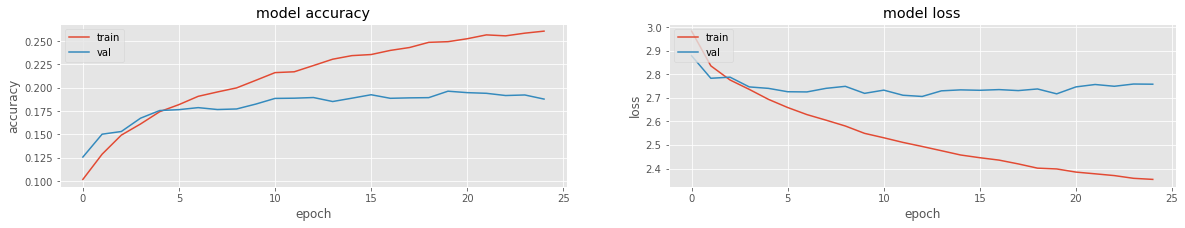

In [40]:
history = history_img_ResNet_transfer.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history['categorical_accuracy'])
axes[0].plot(history['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

You can see that the loss on the validation data increases after a certain time. This means that the model starts to overfit. In addition, an accuracy of just 0,1963 is achieved on the validation data. Therefore, it is probably rather unsuitable for classification in this form.

### Fine-tuning (last conv-layer)
for the finetuneing of the ResNet just train the last Layers and freeze the other layers

In [41]:
FINETUNE = 1    # set or reset FINETUNE
if FINETUNE:
  print('Finetuning the model...')
  # set the parameters, here only freeze blocks 1 to 4
  # The loop freezes all layers UP TO a specific one
  modelResNet152.trainable = True
  set_trainable = False
  for layer in modelResNet152.layers:
  # Replace according to your architecture...
    if layer.name == 'conv5_block1_1_conv':           # For ResNet
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

#ResNet2--> no training befor concanate
modelResNet2 = models.Sequential()                
modelResNet2.add(modelResNet152)
modelResNet2.add(layers.Flatten())
modelResNet2.add(layers.Dropout(0.2))
modelResNet2.add(layers.Dense(256, activation='relu'))
modelResNet2.add(layers.Dropout(0.2))
modelResNet2.add(layers.Dense(NUM_CLASSES, activation='softmax'))
modelResNet2.summary()

Finetuning the model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 21)                5397      
Total params: 63,095,189
Trainable params: 19,700,245
Non-trainable params: 43,394,944
_________

In [42]:
#for fine tuneing set the learnrate very low --> 3*10^-5
optimizer= tf.keras.optimizers.Adam(0.00003)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()
modelResNet2.compile(optimizer=optimizer, loss=loss, metrics =metric)
modelResNet2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 21)                5397      
Total params: 63,095,189
Trainable params: 19,700,245
Non-trainable params: 43,394,944
_________________________________

In [ ]:
# fits the model on batches with real-time data augmentation:
#history_img_Xception = modelResNet.fit(datagen.flow(train_image, train_labels_onehot, batch_size=32),
#                                         validation_data=(test_image, test_labels_onehot),
#                                          epochs=5)

In [ ]:
#finetuning of the Last Layers
history_img_ResNet = modelResNet2.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=25, batch_size=32)

Epoch 1/10
1050/1050 [==============================] - 70s 59ms/step - loss: 2.9806 - categorical_accuracy: 0.1216 - val_loss: 2.8009 - val_categorical_accuracy: 0.1604
Epoch 2/10
1050/1050 [==============================] - 59s 56ms/step - loss: 2.7307 - categorical_accuracy: 0.1838 - val_loss: 2.7081 - val_categorical_accuracy: 0.1929
Epoch 3/10
1050/1050 [==============================] - 58s 55ms/step - loss: 2.5853 - categorical_accuracy: 0.2265 - val_loss: 2.6577 - val_categorical_accuracy: 0.2142
Epoch 4/10
1050/1050 [==============================] - 59s 56ms/step - loss: 2.4282 - categorical_accuracy: 0.2719 - val_loss: 2.6311 - val_categorical_accuracy: 0.2250
Epoch 5/10
1050/1050 [==============================] - 58s 55ms/step - loss: 2.2612 - categorical_accuracy: 0.3152 - val_loss: 2.6133 - val_categorical_accuracy: 0.2415
Epoch 6/10
1050/1050 [==============================] - 58s 55ms/step - loss: 2.0730 - categorical_accuracy: 0.3726 - val_loss: 2.6160 - val_categoric

In [50]:
#save the model to colab
classifier_model.save("saved_model/weights.model_ResNet_l.h5")
#save the model to google drive
classifier_model.save("gdrive/MyDrive/model_ResNet_l.h5")
classifier_model.save_weights("gdrive/MyDrive/model_ResNet_l")


In [ ]:
history = history_img_ResNet.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history['categorical_accuracy'])
axes[0].plot(history['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

### Finetuning of the whole ResNet152

In [ ]:
#Set all parameters to trainable
modelResNet152_fine = modelResNet152
modelResNet152_fine.trainable = True

#Same net like above but all parameters are trainable
modelResNet_fine = models.Sequential()                
modelResNet_fine.add(modelResNet152_fine)
modelResNet_fine.add(layers.Flatten())
modelResNet_fine.add(layers.Dropout(0.2))
modelResNet_fine.add(layers.Dense(128, activation='relu'))
modelResNet_fine.add(layers.Dropout(0.2))
modelResNet_fine.add(layers.Dense(NUM_CLASSES, activation='softmax'))
modelResNet_fine.summary()

In [ ]:
#for fine tuneing set the learnrate very low --> 3*10^-5
optimizer= tf.keras.optimizers.Adam(0.00003)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()
modelResNet_fine.compile(optimizer=optimizer, loss=loss, metrics =metric)
modelResNet_fine.summary()

In [ ]:
#finetuning of all parameters
history_img_ResNet_fine = modelResNet_fine.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=10, batch_size=32)

In [ ]:
history = history_img_ResNet_fine.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history['categorical_accuracy'])
axes[0].plot(history['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

### Model definition
Here a model is defined where a flatten layer is added so that it can later be combined with the text model.

# Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

### BERT + ResNet

In [ ]:
# Merge the text classifier and the CNN pretrained with output 21 dense
merged = tf.keras.layers.Concatenate()([classifier_model.output,modelResNet.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(2048, activation='relu')(dropout)

final_dropout = tf.keras.layers.Dropout(0.2)(dense1)

dense2 = tf.keras.layers.Dense(2048, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense2)

final_model = tf.keras.Model(inputs=[classifier_model.input, modelResNet.input], outputs=output_layer)

### BERT + ResNet 2
both pretrained before on the description and the images an then the parameters are frozen

In [ ]:
#Put a flatten on top to the ResNet152, so that the output fits to the model
modelResNet_pretrained = models.Sequential()                
modelResNet_pretrained.add(modelResNet152)
modelResNet_pretrained.add(layers.Flatten())

#Freeze the parameter of the pretrained BERT Modell
modelBERT_fine.trainable=False

In [ ]:
merged = tf.keras.layers.Concatenate()([model_BERT2.output,modelResNet_pretrained.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(100, activation='relu')(dropout)

dropout = tf.keras.layers.Dropout(0.2)(dense1)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dropout)

final_model = tf.keras.Model(inputs=[model_BERT2.input, modelResNet_pretrained.input], outputs=output_layer)

Bert + Xception

In [ ]:
# Merge the text classifier and the CNN
merged = tf.keras.layers.Concatenate()([classifier_model.output,modelXception.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(128, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[classifier_model.input, modelXception.input], outputs=output_layer)

In [ ]:
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
resnet152_input (InputLayer)    [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
resnet152 (Functional)          (None, 3, 3, 2048)   58370944    resnet152_input[0][0]            
____________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Split the data into 80% training and 20% test

In [ ]:
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [ ]:
#Split the data
p = int((len(images)*100)/100)

#Image Data
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]

#Text Data
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

text_train = np.asarray(train_data_raw)
text_test = np.asarray(test_data_raw)


In [ ]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print('Shape of train',text_train.shape)
print("Shape of Validation ",text_test.shape)

Shape of train (42000, 80, 80, 3)
Shape of Validation  (0, 80, 80, 3)
Shape of train (42000, 21)
Shape of Validation  (0, 21)
Shape of train (42000,)
Shape of Validation  (0,)


## Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
adam = tf.keras.optimizers.Adam(learning_rate=3e-5)
#optimizer = adam
final_model.compile(optimizer = adam,
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

#Precision : TP /(TP+FP)
#Recall: TP/(TP+FN)

## Train the model
During training on a supervised machine learning prediction task, the parameters of the neural network - the weights- are the embeddings will modify to minimize the loss.

In [ ]:
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 2
VALIDATION_SPLIT = .1
L2_REGULARIZATION = 0.01

In [ ]:
#transfer learning:
tf.debugging.set_log_device_placement(True)
try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([text_train, image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test,image_test,], label_test))
except RuntimeError as e:
  print(e)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
656/656 [==============================] - 229s 348ms/step - loss: 0.0551 - accuracy: 0.9867 - precision: 0.9771 - recall: 0.9731
Epoch 2/2
656/656 [==============================] - 226s 345ms/step - loss: 0.0414 - accuracy: 0.9898 - precision: 0.9788 - recall: 0.9755


In [ ]:
#save the model to colab
classifier_model.save("saved_model/weights.final_model4.h5")
#save the model to google drive
classifier_model.save("gdrive/MyDrive/final_model4.h5")
classifier_model.save_weights("gdrive/MyDrive/final_model4")

#Different Models an scores
#final_model1, classifier_model + modelResNet both pretrained (val_acc pretrain: 83,43), 3 epochs just train the last 3 layers, 3 epochs finetuning
#final_model2, BERT +ResNEt dense2048 as output, not pretrained

 # **Make predictions on validation data**

In [ ]:
predictions = final_model.predict([text_test,image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

2100/2100 - 86s


In [ ]:
accuracy_score(y_test, classes)

0.9119047619047619

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,classes)

## Confusion Matrix
In the confusion Matrix you can see the highest prediction error is in categories which are very similar like beauty and all beauty or baby and babyproducts. So its very hard to determine the correct categorie for the net.

Text(0.5, 114.0, 'Predicted label')

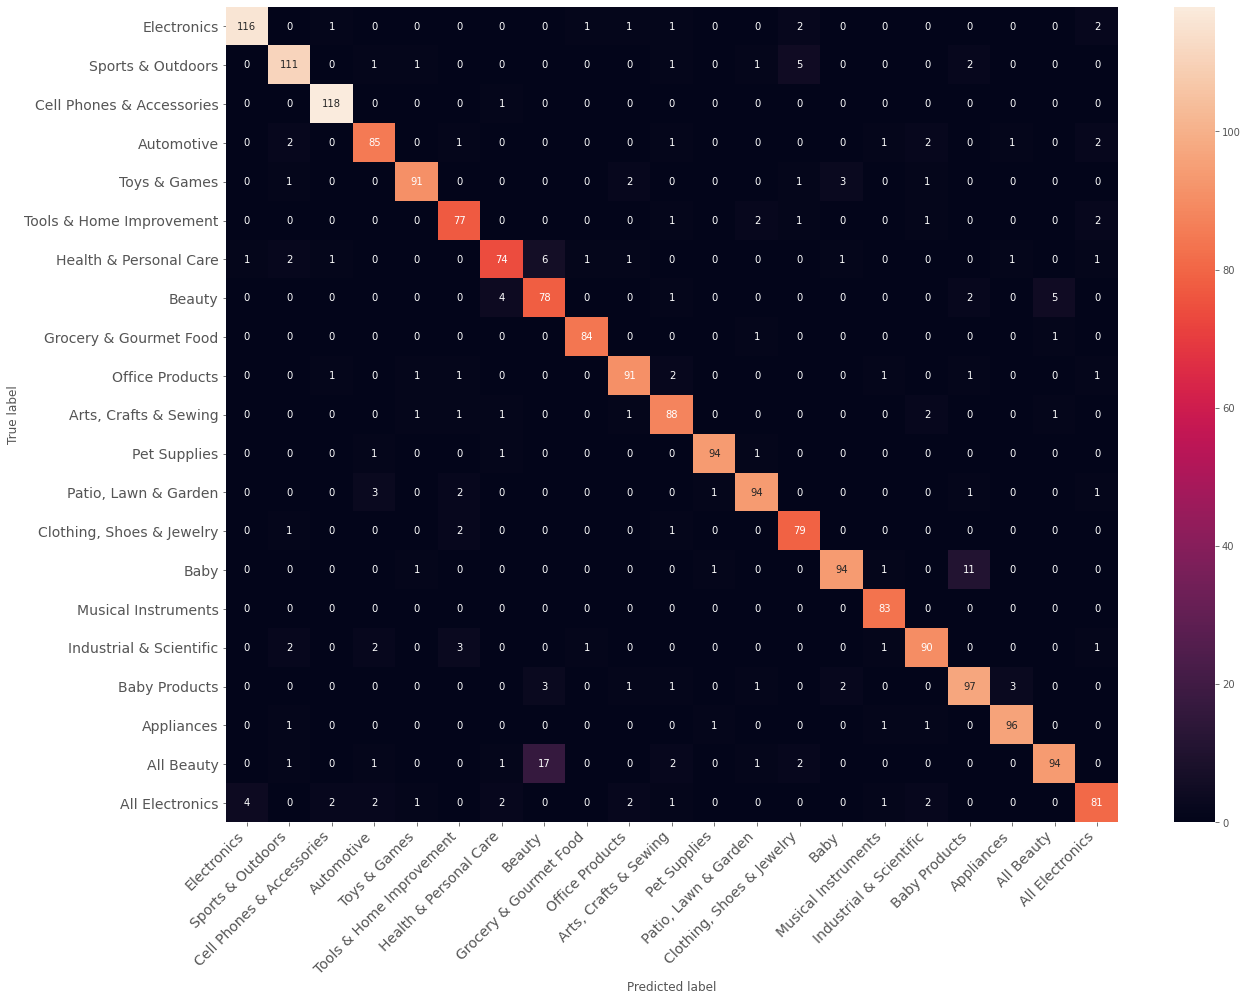

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

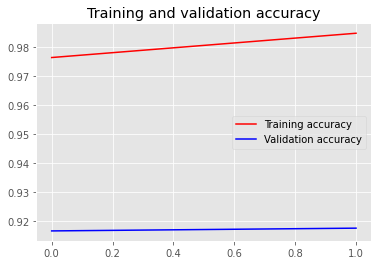

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

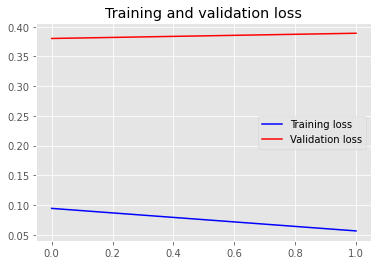

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Read the test data

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            token_list = filter_description(str(title) + ' ' + str(description))#changed
            #adds the words of the current token_list to the corpus (Textsammlung)
            test_corpus.append(token_list)
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
test_corpus = np.asarray(test_corpus)
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

# **Make predictions on test data**

In [ ]:
#load other weigths for prediction
#final_model.load_weights("static/weights.h5")

In [ ]:
pred = final_model.predict([test_corpus,test_images, ],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 248s


# Create submission file

In [ ]:
#write in the submission file of google drive
import csv
with open('gdrive/MyDrive/submission3.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])